In [1]:
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore
from datetime import datetime
import xarray as xr
from xarray.backends import NetCDF4DataStore
import xarray as xr

best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')

best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()

query = ncss.query()

query.lonlat_box(north=83, south=7, east=310, west=190).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Temperature_surface')

data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

list(data)

temp_3d = data['Temperature_surface']

# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    raise ValueError('No time variable found for ' + var.name)

time_1d = find_time_var(temp_3d)
lat_1d = data['latitude']
lon_1d = data['longitude']
print(time_1d)

ModuleNotFoundError: No module named 'siphon'

Text(0.5, 1.0, 'Temperature forecast (°F) for 2025-02-24T06:00:00.000000000Z')

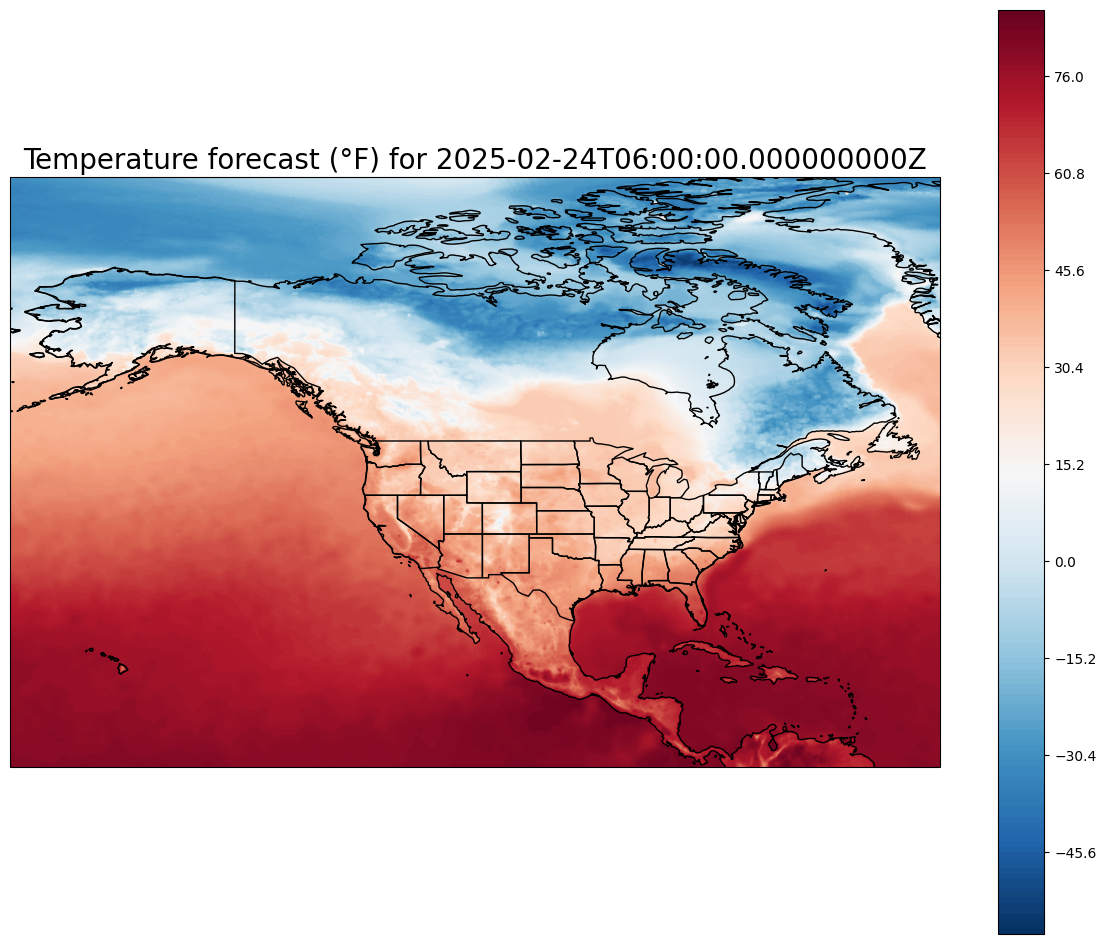

In [8]:
import numpy as np
from netCDF4 import num2date
from metpy.units import units
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables

# Reduce the dimensions of the data and get as an array with units
temp_2d = temp_3d.metpy.unit_array.squeeze()

# Combine latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-170, -50, 7, 83], crs=ccrs.PlateCarree())

# Add coastlines to the plot
ax.coastlines(resolution='50m', color='black', linewidth=1)

# Retrieve the state boundaries using cFeature and add to plot
ax.add_feature(cfeature.STATES, edgecolor='black')

# Contour temperature at each lat/long
contours = ax.contourf(lon_2d, lat_2d, temp_2d.to('degF'), 200, transform=ccrs.PlateCarree(), cmap='RdBu_r')

#Plot a colorbar to show temperature and reduce the size of it
fig.colorbar(contours)

# Make a title with the time value
ax.set_title(f'Temperature forecast (\u00b0F) for {time_1d[0].values}Z', fontsize=20)

# # Plot markers for each lat/long to show grid points for 0.25 deg GFS
# ax.plot(lon_2d.flatten(), lat_2d.flatten(), linestyle='none', marker='o',
#         color='black', markersize=2, alpha=0.3, transform=ccrs.PlateCarree());

## Extract Multiple Days of Forecasts

In [14]:
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
from netCDF4 import num2date
from metpy.units import units
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Access the GFS Best dataset
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()

# Define forecast period: now until 16 days out
start_time = datetime.utcnow()
end_time = start_time + timedelta(days=16)

query = ncss.query()
query.lonlat_box(north=83, south=7, east=310, west=190)
# Use a time range instead of a single time
query.time_range(start_time, end_time)
query.accept('netcdf4')
query.variables('Temperature_surface')

# Retrieve the data and open it as an xarray dataset
data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

/var/folders/tr/24ngf6ld159361lgswj_6ch00000gn/T/ipykernel_61700/1393116750.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import pytz
import imageio
import os

# Define the timezone for US Central Time
central_tz = pytz.timezone("America/Chicago")

# --- (Assuming you've already queried and loaded your data) ---

# temp_3d is your Temperature_surface variable
# time_1d is the associated time coordinate from temp_3d
# lon_2d, lat_2d are the longitude and latitude grids

# Filter forecast times to those at exact 6-hour intervals (assuming time_1d is a numpy array of numpy.datetime64)
forecast_times = []
start_time_np = np.datetime64(time_1d.values[0])
for t in time_1d.values:
    delta_hours = (t - start_time_np) / np.timedelta64(1, 'h')
    if np.isclose(delta_hours % 6, 0, atol=1e-2):
        forecast_times.append(t)

print(f"Found {len(forecast_times)} forecast times at 6-hour intervals over the next 16 days.")

# Create a directory for the frames if it doesn't exist
frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)
frame_filenames = []

# Loop over each forecast time and generate a plot
for t in forecast_times:
    # Convert numpy.datetime64 to Python datetime in UTC
    dt_utc = datetime.utcfromtimestamp((t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
    # Convert to Central Time
    dt_central = dt_utc.replace(tzinfo=pytz.utc).astimezone(central_tz)
    # Format the central time string for the title
    time_str = dt_central.strftime("%Y-%m-%d %H:%M %Z")
    
    # Select the temperature field for the current forecast time and remove extra dimensions
    temp_2d = temp_3d.sel(time=t).metpy.unit_array.squeeze()
    
    # Create the figure and axis with Cartopy projection
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-170, -50, 7, 83], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor='black')
    
    # Contour the temperature (converted to °F)
    contours = ax.contourf(lon_2d, lat_2d, temp_2d.to('degF'), 200,
                           transform=ccrs.PlateCarree(), cmap='RdBu_r')
    # Add a colorbar
    fig.colorbar(contours, ax=ax)
    
    # Set the title using the Central Time string
    ax.set_title(f'Temperature forecast (°F) for {time_str}', fontsize=20)
    
    # Save the figure to a PNG file
    frame_filename = os.path.join(frames_dir, f"forecast_{dt_central.strftime('%Y%m%d_%H%M')}.png")
    plt.savefig(frame_filename, bbox_inches='tight')
    plt.close(fig)
    frame_filenames.append(frame_filename)

# Create a GIF from the saved frames using imageio
gif_filename = "forecast_animation.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for filename in frame_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as {gif_filename}")

Found 64 forecast times at 6-hour intervals over the next 16 days.


/var/folders/tr/24ngf6ld159361lgswj_6ch00000gn/T/ipykernel_61700/3474970909.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  dt_utc = datetime.utcfromtimestamp((t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
/var/folders/tr/24ngf6ld159361lgswj_6ch00000gn/T/ipykernel_61700/3474970909.py:37: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt_utc = datetime.utcfromtimestamp((t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
/var/folders/tr/24ngf6ld159361lgswj_6ch00000gn/T/ipykernel_61700/3474970909.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  dt_utc = datetime.utcfromtimestamp((t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
/var/folders/tr/24ngf6ld159361lgsw

GIF saved as forecast_animation.gif
